## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt


# -------------------- Globals ---------------------------

# all signals were sampled at 125 Hz
FS = 125 

# the window size, in samples, for computing a local heartrate
WIN_SAMPLES = 1536 

# min and max beats per second for heatrate
# (this is used for the bandpass filter)
min_bps, max_bps = 40/60, 240/60 



# --------------------------------------------------------



def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals, along with an array of times in seconds
    """
    data = sp.io.loadmat(data_fl)['sig']
    ts = np.arange(0,data.shape[1] / FS, 1./FS)
    return np.vstack((data[2:],ts.reshape(1,-1)))

def LoadTroikaRefFile(ref_fl):
    """
    Loads heartrate reference from reference data file.
    These are the files named REF_*.mat, which are
    ground truth heartrate in bpm derived from EKG data.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ref_bpm = LoadTroikaDataFile(ref_fls[0])

    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array for reference heartrate, and a numpy array for associated timestamps in seconds
    """
    ref_bpm = sp.io.loadmat(ref_fl)['BPM0'].T
    ref_ts = np.arange(4., ref_bpm.shape[1]*2+4,2.)
    return np.vstack((ref_bpm,ref_ts.reshape(1,-1)))


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band=(min_bps, max_bps), fs=FS):
    """
    Bandpass filter a signal; this is copied from the exploration notebooks.
    
    Args:
        signal: a numpy array of the signal
        pass_band: array_like; a length-2 sequence giving the critical frequencies
        fs: sample rate
    
    Returns:
        Bandpass filtered signal (still in time domain, or whatever was the original domain)
    """
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def choose_ppg_peak(ppg_fft, freqs, ppg_peaks, accx_peaks, accy_peaks, accz_peaks, tolerance, prev_pred):
    """
    Choose a preferred peak index given the fft of a ppg and
    some information about peaks in ppg and accelerometer.
    
    Args:
        ppg_fft: (numpy array) the absolute value of the fft of the ppg signal
        freqs: (numpy array) the corresponding list of frequencies
        ppg_peaks: (list of pairs) a list of (ppg peak index, peak prominence) pairs
        accx_peaks: (array) a list of of peak indices for the x channel of the accelerometer
        accy_peaks: (array) a list of of peak indices for the y channel of the accelerometer
        accz_peaks: (array) a list of of peak indices for the z channel of the accelerometer
        tolerance: (float) the distance in frequency samples such that a ppg peak index
                   and an accelerometer peak index that are within that distance would be
                   considered to be uncomfortably close. The algorithm will somewhat try to 
                   avoid choosing a ppg peak index that is too close to an accelerometer peak index.
        prev_pred: previous prediction in Hz, or None if there isn't one
    
    Returns:
        The index (not frequency!) of the chosen peak in the ppg fft
    """
    
    # if there are no peaks in the list, fall back to just giving argmax
    if len(ppg_peaks)==0:
        return ppg_fft.argmax()
    
    # attenuate prominence of ppg peaks that are too close to accelerometer peaks,
    # if there are accelerometer peaks
    for acc_i in (accx_peaks, accy_peaks, accz_peaks):
        if len(acc_i)>0:

            for j in range(len(ppg_peaks)):

                peak_idx, prominence = ppg_peaks[j]
                
                #distance in frequency samples from peak_idx to nearest acc_i peak
                dist_to_acc = min(np.abs(peak_idx - acc_peak_idx) for acc_peak_idx in acc_i)

                if dist_to_acc <= tolerance:
                    prominence *= 0.8

                ppg_peaks[j] = (peak_idx, prominence)
        
     
    # take top N ppg peak indices in terms of prominence
    N=3
    ppg_peaks_topN = sorted(
        ppg_peaks,
        key = lambda x : x[1],
        reverse=True
    )[:N]
    
    # if there was no previous prediction, just choose the top choice now
    if prev_pred is None:
        return ppg_peaks_topN[0][0]
    
    # of those top N, choose the one closest to the previous prediction
    return min(
        [(peak_idx, np.abs(freqs[peak_idx] - prev_pred)) for peak_idx,_ in ppg_peaks_topN],
        key = lambda x:x[1]
    )[0]


def RunPulseRateAlgorithmPred(data_fl, ref_fl):
    """
    Run the pulse rate algorithm on the given .mat data and reference files, returning errors, confidences,
    and the predicted pulse rate time series.
    
    Args:
        data_fl: Names of the .mat file that contains signal data
        ref_fl: Names of the .mat file that contains reference data
        
    Returns:
        errors: a numpy array of absolute differences between the ground truth
                and the predicted heartrates, in beats per minute
        confidences: a numpy array of confidence values for each prediction
        pred_ts: a numpy array of timestamps in seconds for the predictions
        preds: a numpy array of heartrate predictions, in beats per minute
    """
    
    # Load data using LoadTroikaDataFile
    ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)
    ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
    
    # magnitude of acceleration
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
        
    # run bandpass filter
    ppg = BandpassFilter(ppg)
    accx, accy, accz, acc = map(BandpassFilter, (accx, accy, accz, acc))
    
    # loop over windows of size WIN_SAMPLES samples, in 2 second increments
    errors, confidences, pred_ts, preds = [], [], [], []
    prev_pred = None
    for i in range(0,len(ppg)-WIN_SAMPLES, 2*FS):
        
        # Compute absolute value of ffts
        ppg_fft = np.abs(np.fft.rfft(ppg[i:i+WIN_SAMPLES]))
        accx_fft, accy_fft, accz_fft, acc_fft = map(
            lambda a : np.abs(np.fft.rfft(a[i:i+WIN_SAMPLES])),
            (accx, accy, accz, acc)
        )
        freqs = np.fft.rfftfreq(WIN_SAMPLES,1/FS)
        freq_sample_rate = len(freqs)/freqs[-1] # in samples per Hz

        # Crop the ffts and freqs array to the band we care about
        band_mask = (freqs >= min_bps) & (freqs <= max_bps)
        freqs = freqs[band_mask]
        accx_fft, accy_fft, accz_fft, acc_fft = map(
            lambda a : a[band_mask],
            (accx_fft, accy_fft, accz_fft, acc_fft)
        )
        ppg_fft = ppg_fft[band_mask]
        
        # find peaks in the ppg and fft frequency domain, paying attention to prominence
        ppg_peaks, ppg_peak_properties = sp.signal.find_peaks(ppg_fft, prominence=1000, wlen=2*freq_sample_rate*0.8, distance=0.1*freq_sample_rate)
        accx_peaks, _ = sp.signal.find_peaks(accx_fft, prominence=10000/400, wlen=freq_sample_rate*0.8, distance=0.2*freq_sample_rate)
        accy_peaks, _ = sp.signal.find_peaks(accy_fft, prominence=10000/400, wlen=freq_sample_rate*0.8, distance=0.2*freq_sample_rate)
        accz_peaks, _ = sp.signal.find_peaks(accz_fft, prominence=10000/400, wlen=freq_sample_rate*0.8, distance=0.2*freq_sample_rate)
        
        # apply algorithm to choose a preferred peak index
        peak_index = choose_ppg_peak(
            ppg_fft,
            freqs,
            list(zip(ppg_peaks,ppg_peak_properties['prominences'])),
            accx_peaks, accy_peaks, accz_peaks,
            0.35 * freq_sample_rate,
            prev_pred
        )
                
        # attenuate ppg amplitudes based on accelerometer amplitudes; used for computing confidence
        attenuation_param = acc_fft.max()/3
        ppg_fft_attenuated = ppg_fft * (attenuation_param/(attenuation_param+acc_fft))
        
        # compute confidence
        window_half_width = freq_sample_rate * 0.14  # in frequency samples
        confidence = ppg_fft_attenuated[int(round(peak_index - window_half_width)):int(round(peak_index + window_half_width))].sum()/ppg_fft_attenuated.sum()
        
        # the ground truth beats per second, just past the end of the interval
        ekg_bps = np.interp(ts[i+WIN_SAMPLES],ref_ts,ref_bpm) / 60.
        
        # compute error, convert back to bpm
        error = np.abs(freqs[peak_index] - ekg_bps) * 60.
        
        errors.append(error)
        confidences.append(confidence)
        pred_ts.append((i+WIN_SAMPLES)/FS)
        preds.append(freqs[peak_index] * 60.)
        
        prev_pred = freqs[peak_index]
        


    # Return absolute errors and confidences as a 2-tuple of numpy arrays.
    errors, confidences, pred_ts, preds = map(np.array, (errors, confidences, pred_ts, preds))
    return errors, confidences, pred_ts, preds

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Run the pulse rate algorithm on the given .mat data and reference files, returning only errors and confidences
    
    Args:
        data_fl: Names of the .mat file that contains signal data
        ref_fl: Names of the .mat file that contains reference data
        
    Returns:
        errors: a numpy array of absolute differences between the ground truth
                and the predicted heartrates, in beats per minute
        confidences: a numpy array of confidence values for each prediction
    """
    errors, confidences, _, _ = RunPulseRateAlgorithmPred(data_fl, ref_fl)
    return errors, confidences

In [2]:
Evaluate()

11.844843398396595

# Data Exploration

(Many of the following cells aided the writing of the algorithms above)

In [3]:
data_fls, ref_fls = LoadTroikaDataset()

# The duration in minutes for each subject
[LoadTroikaDataFile(data_fl).shape[1] / FS / 60. for data_fl in data_fls]

[5.0582666666666665,
 5.046666666666667,
 4.798533333333333,
 3.6768,
 4.966666666666667,
 4.977066666666667,
 5.1164,
 4.886666666666667,
 5.4403999999999995,
 5.072266666666667,
 4.866666666666666,
 4.975466666666667]

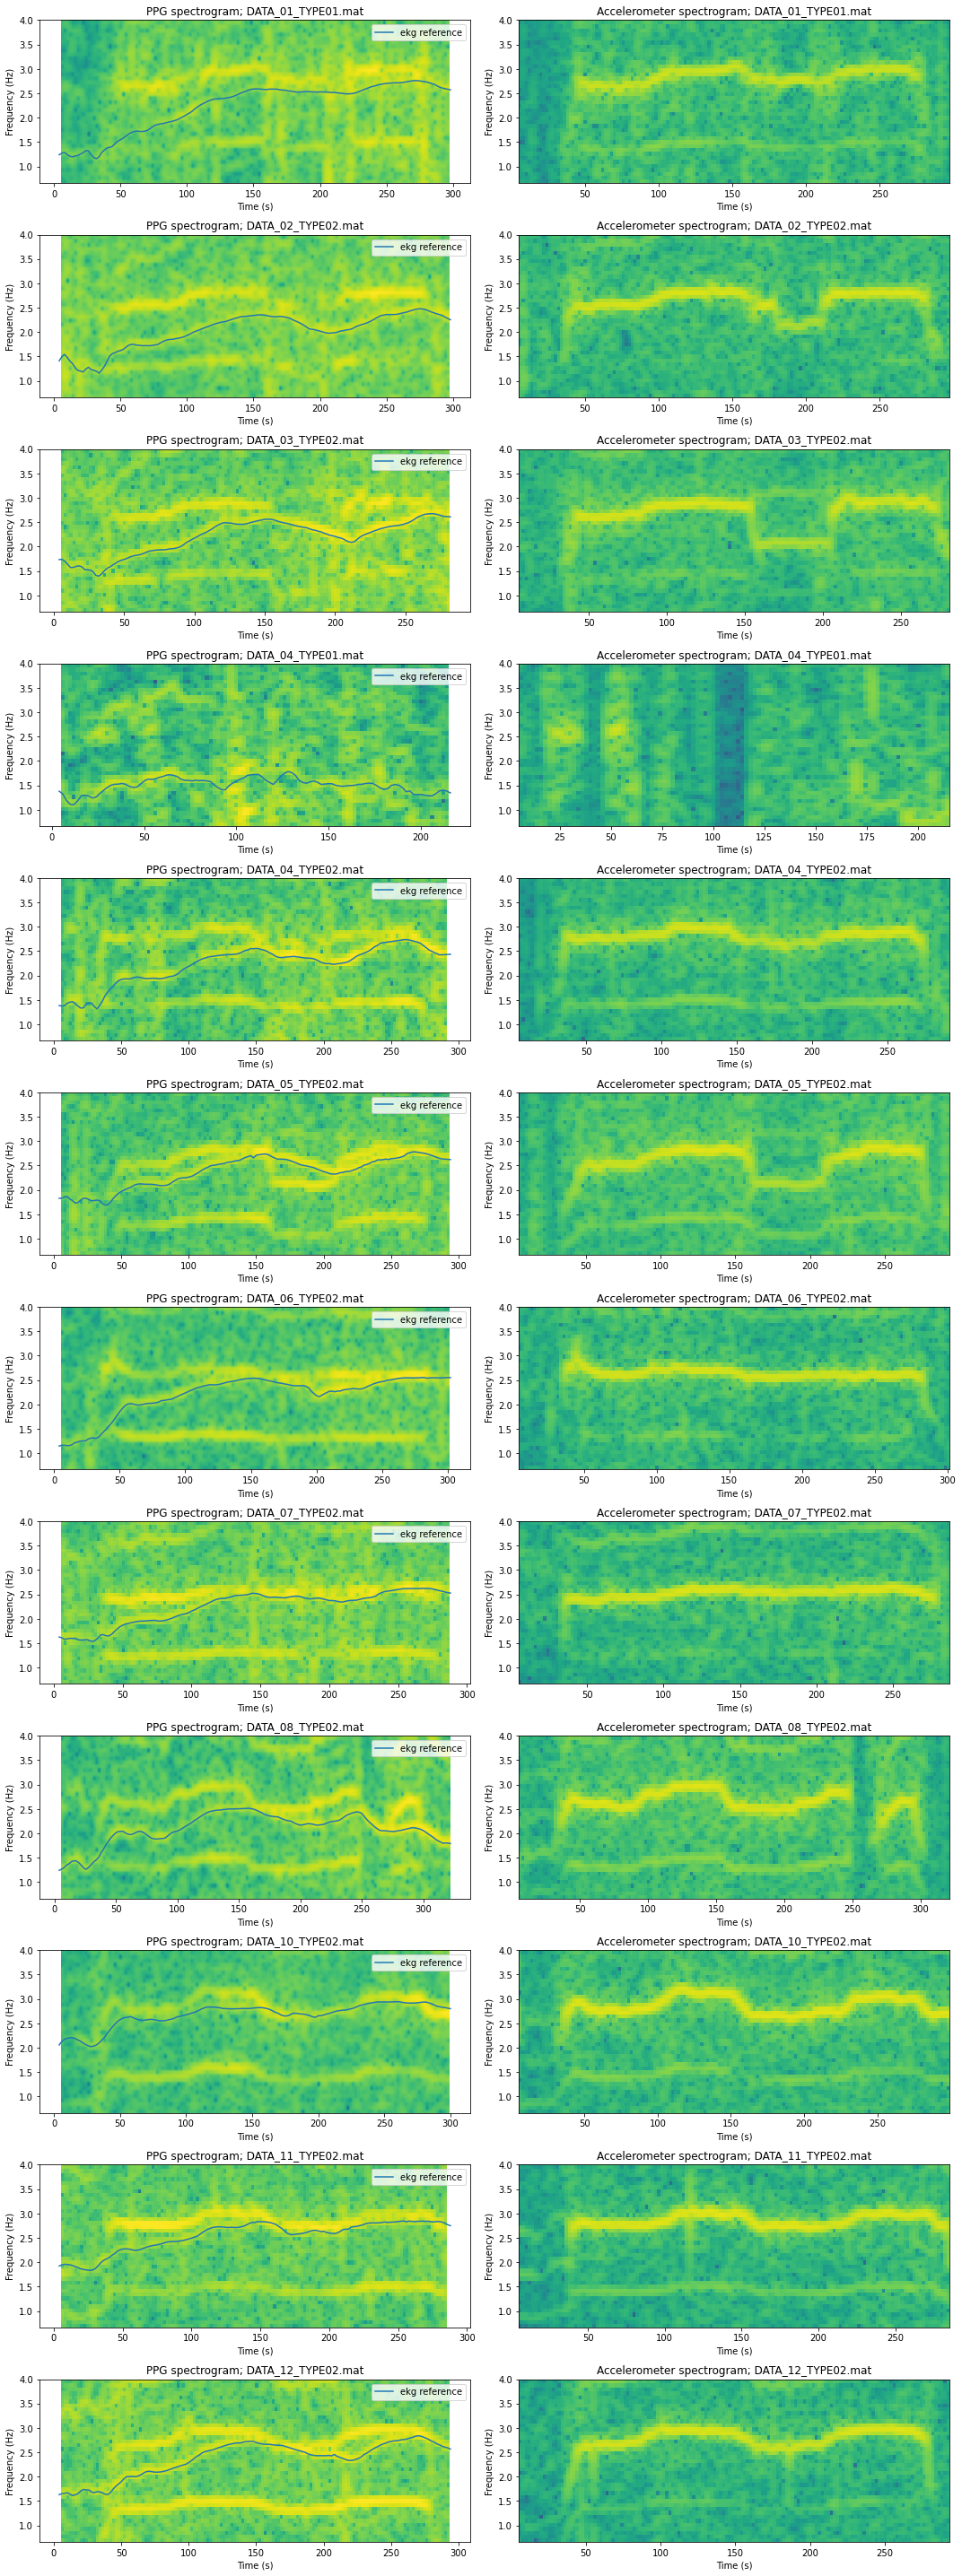

In [4]:
# spectrograms of the unfiltered data, with the reference heartrate superimposed on top
fig, axs = plt.subplots(len(data_fls), 2, figsize=(15,40))
for axrow, data_fl, ref_fl in zip(axs, data_fls, ref_fls):
    ax1, ax2 = axrow
    ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)

    ax1.specgram(x=ppg,Fs=FS, NFFT=WIN_SAMPLES, noverlap=WIN_SAMPLES-2*FS)
    ax1.plot(ref_ts,ref_bpm/60., label='ekg reference')
    ax1.set_title("PPG spectrogram; " + data_fl.split('/')[-1])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(min_bps, max_bps)
    ax1.legend()
    
    ax2.specgram(x=acc,Fs=FS, NFFT=WIN_SAMPLES, noverlap=WIN_SAMPLES-2*FS)
    ax2.set_title("Accelerometer spectrogram; " + data_fl.split('/')[-1])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_ylim(min_bps, max_bps)
    
    
    
fig.tight_layout()
plt.show()

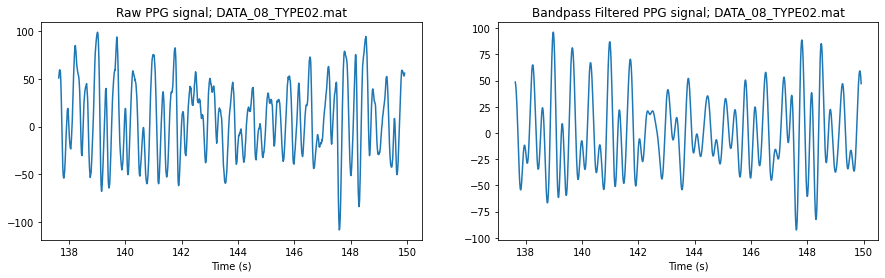

In [5]:
# plot random chunk of data, view unfiltered and filtered
# run this cell many times to explore

data_fl = data_fls[np.random.randint(0,len(data_fls))]
ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
ppg_filtered = BandpassFilter(ppg)
i = np.random.randint(0,len(ts)-WIN_SAMPLES)
j = i + WIN_SAMPLES
fig, axs = plt.subplots(1,2,figsize=(15,4))
ax1,ax2=axs
ax1.plot(ts[i:j], ppg[i:j])
ax1.set_title('Raw PPG signal; '+data_fl.split('/')[-1])
ax1.set_xlabel('Time (s)')
ax2.plot(ts[i:j], ppg_filtered[i:j])
ax2.set_title('Bandpass Filtered PPG signal; '+data_fl.split('/')[-1])
ax2.set_xlabel('Time (s)')
plt.show()

16751


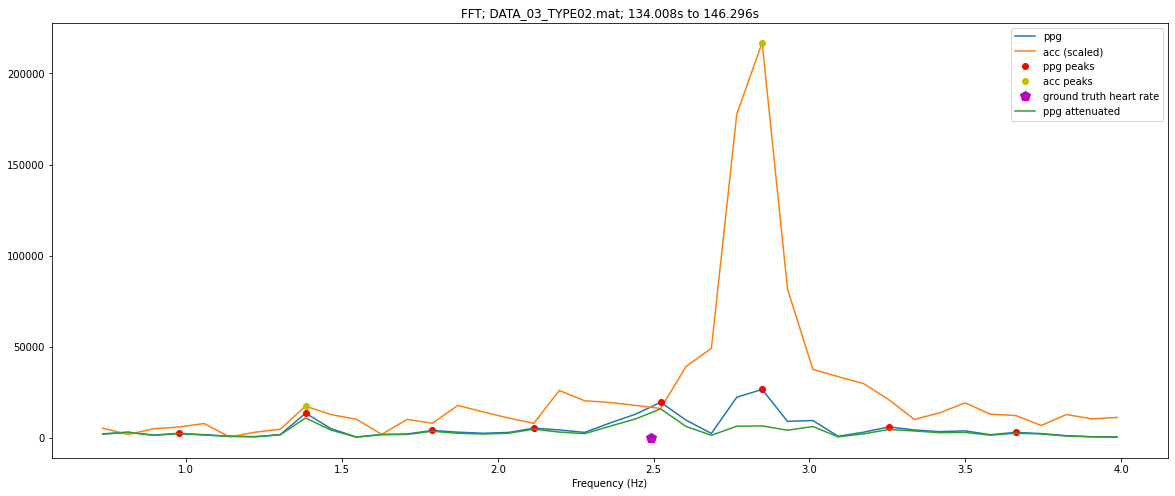

freq: 2.522786458333333
conf:   0.26830454636826245
error: 0.029456418333332568
0.9765625 ...	 1022.7205970209709
1.3834635416666665 ...	 12904.941408911667
1.7903645833333333 ...	 1541.9319303777856
2.1158854166666665 ...	 2327.0849717020815
2.522786458333333 ...	 16511.906044824787
2.8483072916666665 ...	 24118.751205010052
3.255208333333333 ...	 4293.602788460273
3.662109375 ...	 1288.029512075094


In [6]:
# plot FTTs in a random chunk of filtered data
# run this cell many times to explore

rand_index = np.random.randint(0,len(data_fls))
# rand_index=9
data_fl, ref_fl = data_fls[rand_index], ref_fls[rand_index]
ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)
ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
acc = np.sqrt(accx**2 + accy**2 + accz**2)
ppg_filtered = BandpassFilter(ppg)
acc_filtered = BandpassFilter(acc)
i=np.random.randint(0,len(ppg_filtered)-WIN_SAMPLES)
# i=14875
print(i)
ppg_fft = np.abs(np.fft.rfft(ppg_filtered[i:i+WIN_SAMPLES],n=WIN_SAMPLES),)
acc_fft = np.abs(np.fft.rfft(acc_filtered[i:i+WIN_SAMPLES],n=WIN_SAMPLES))
freqs = np.fft.rfftfreq(WIN_SAMPLES,1/FS)
freq_sample_rate = len(freqs)/freqs[-1] # in samples per Hz

# Crop the ffts and freqs array to the band we care about
band_mask = (freqs >= min_bps) & (freqs <= max_bps)
freqs = freqs[band_mask]
acc_fft = acc_fft[band_mask]
ppg_fft = ppg_fft[band_mask]


# the ground truth beats per second at midpoint of interval
ekg_bps = np.interp(ts[i+WIN_SAMPLES//2],ref_ts,ref_bpm) / 60. 

ppg_peaks, ppg_peak_properties = sp.signal.find_peaks(ppg_fft, prominence=1000, wlen=freq_sample_rate*0.8, distance=0.1*freq_sample_rate)
acc_peaks, acc_peak_properties = sp.signal.find_peaks(acc_fft, prominence=10000/400, wlen=freq_sample_rate*1., distance=0.2*freq_sample_rate)

# do the same stuff for the three accelerometer channels:
acc_peaks_by_channel = []
acc_fft_by_channel = []
for a in (accx, accy, accz):
    a_filtered = BandpassFilter(a)
    afft = np.abs(np.fft.rfft(a_filtered[i:i+WIN_SAMPLES],n=WIN_SAMPLES))
    afft = afft[band_mask]
    a_peaks, a_peak_properties = sp.signal.find_peaks(afft, prominence=10000/400, wlen=freq_sample_rate*0.8, distance=0.2*freq_sample_rate)
    acc_peaks_by_channel.append(a_peaks)
    acc_fft_by_channel.append(afft)
    
plt.figure(figsize=(20,8))
plt.plot(freqs,ppg_fft,label='ppg')
plt.plot(freqs,400*acc_fft,label='acc (scaled)')
# plt.plot(freqs,400*acc_fft_by_channel[0],label='accx (scaled)')
# plt.plot(freqs,400*acc_fft_by_channel[1],label='accy (scaled)')
# plt.plot(freqs,400*acc_fft_by_channel[2],label='accz (scaled)')
plt.xlabel('Frequency (Hz)')
plt.title('FFT; {}; {}s to {}s'.format(data_fl.split('/')[-1], i/FS, (i+WIN_SAMPLES)/FS))
plt.plot(freqs[ppg_peaks], ppg_fft[ppg_peaks], 'r.', markersize=12, label='ppg peaks')
plt.plot(freqs[acc_peaks], 400*acc_fft[acc_peaks], 'y.', markersize=12, label='acc peaks')
plt.plot(ekg_bps,0,'mp',markersize=10, label='ground truth heart rate')

# attenuate ppg amplitudes based on accelerometer amplitudes
attenuation_param = acc_fft.max()/3
ppg_fft_attenuated = ppg_fft * (attenuation_param/(attenuation_param+acc_fft))
plt.plot(freqs, ppg_fft_attenuated, label='ppg attenuated')


plt.legend()
plt.show()

peak_index = choose_ppg_peak(
    ppg_fft,
    freqs, 
    list(zip(ppg_peaks,ppg_peak_properties['prominences'])), 
    acc_peaks_by_channel[0], 
    acc_peaks_by_channel[1], 
    acc_peaks_by_channel[2], 
    0.2 * freq_sample_rate,
    None
)

window_half_width = freq_sample_rate * 0.14  # in frequency samples
confidence = ppg_fft_attenuated[int(round(peak_index - window_half_width)):int(round(peak_index + window_half_width))].sum()/ppg_fft_attenuated.sum()
error = np.abs(freqs[peak_index] - ekg_bps)



print("freq: {}\nconf:   {}\nerror: {}".format(freqs[peak_index] ,confidence, error))
for f, p in zip(freqs[ppg_peaks],ppg_peak_properties['prominences']):
    print(f,"...\t",p)

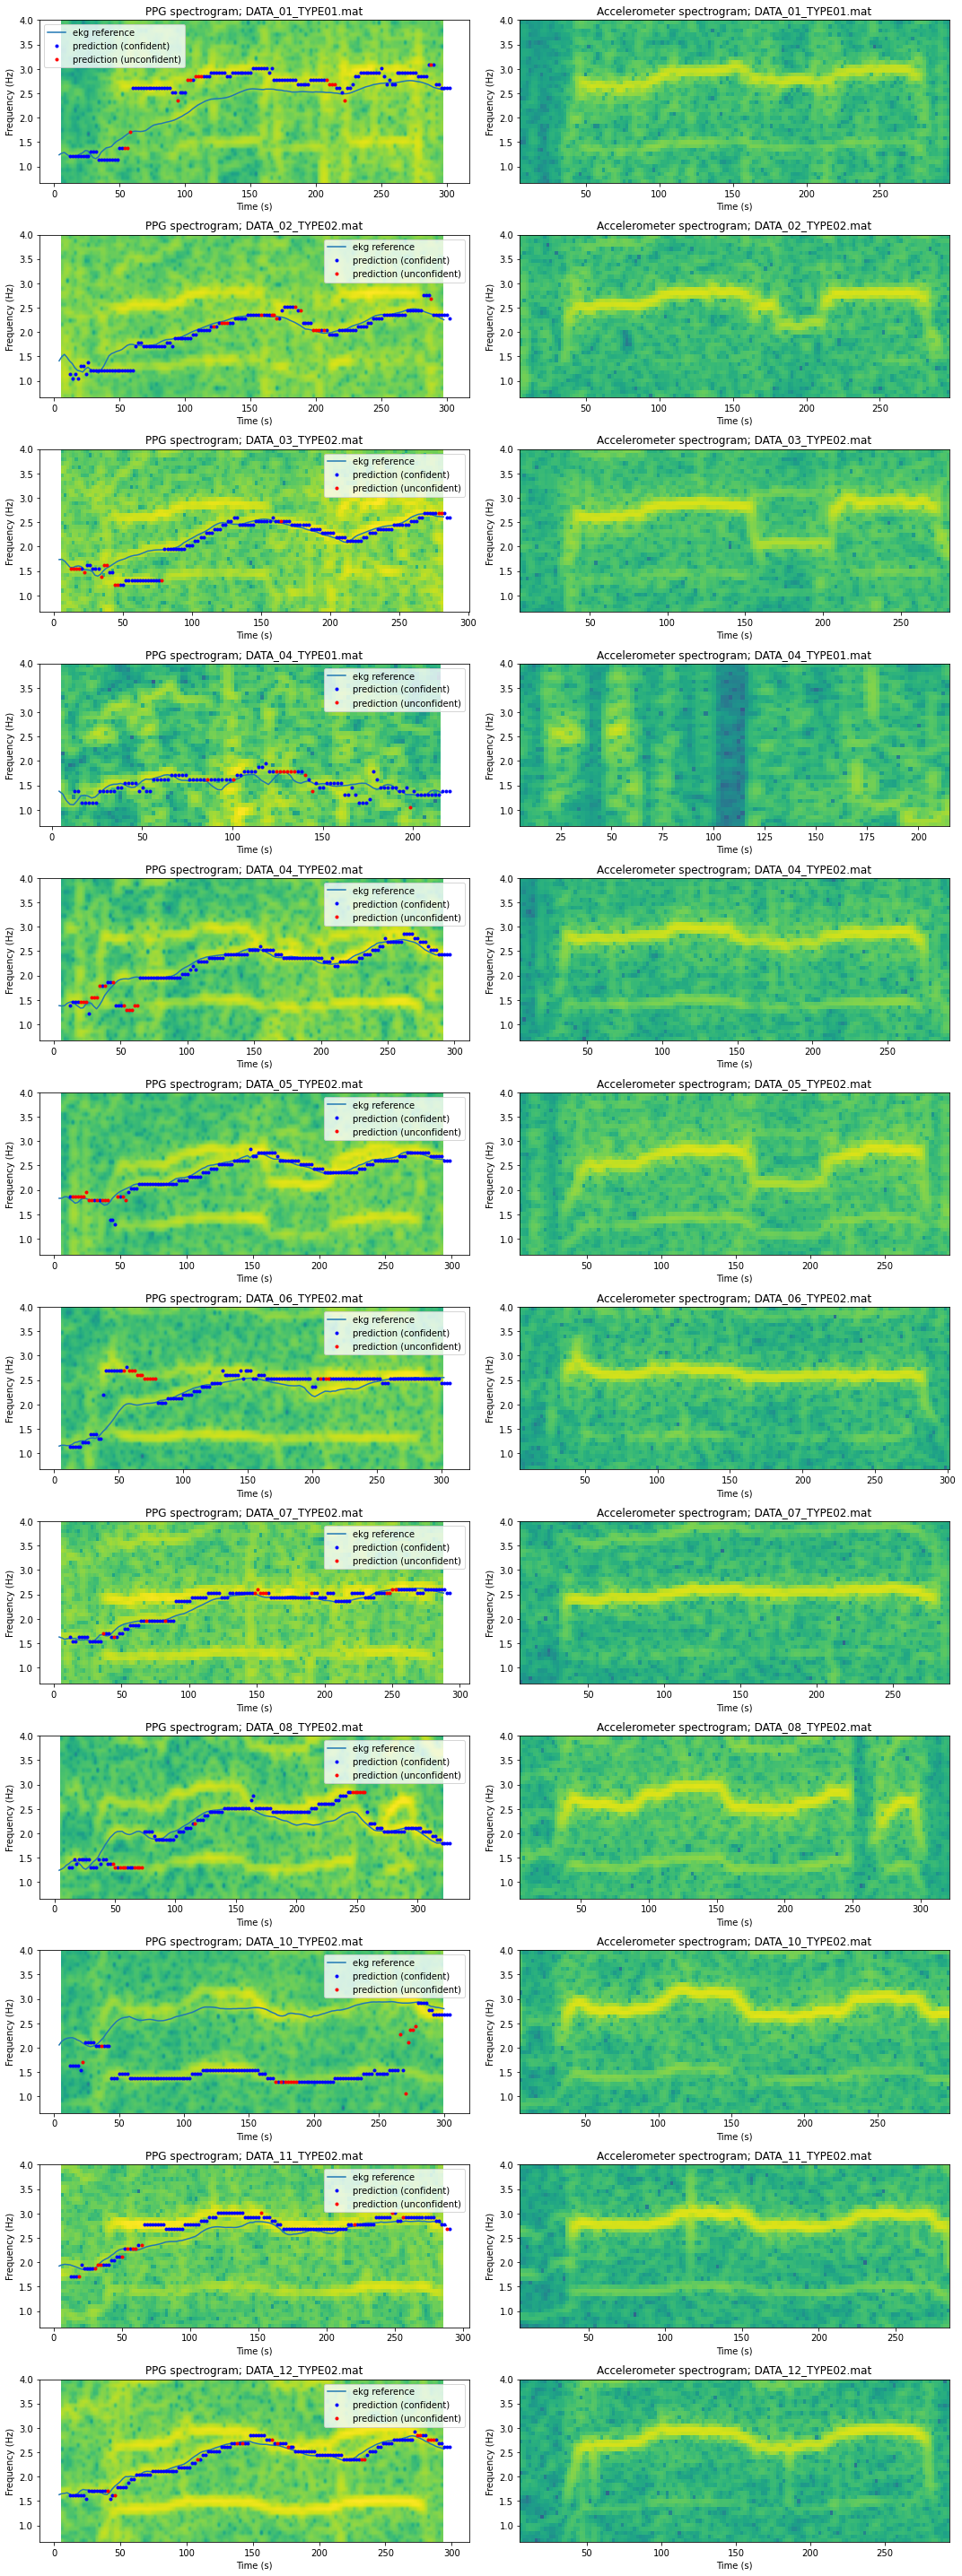

In [7]:
# spectrograms of the unfiltered data, with the reference heartrate and prediction superimposed on top
fig, axs = plt.subplots(len(data_fls), 2, figsize=(15,40))
for axrow, data_fl, ref_fl in zip(axs, data_fls, ref_fls):
    ax1, ax2 = axrow
    ppg, accx, accy, accz, ts = LoadTroikaDataFile(data_fl)
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    ref_bpm, ref_ts = LoadTroikaRefFile(ref_fl)

    ax1.specgram(x=ppg,Fs=FS, NFFT=WIN_SAMPLES, noverlap=WIN_SAMPLES-2*FS)
    ax1.plot(ref_ts,ref_bpm/60., label='ekg reference')
    ax1.set_title("PPG spectrogram; " + data_fl.split('/')[-1])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(min_bps, max_bps)
    
    errors, confidences, pred_ts, preds = RunPulseRateAlgorithmPred(data_fl, ref_fl)
    percentile90_confidence = np.percentile(confidences, 10)
    conf_mask = (confidences >= percentile90_confidence)
    unconf_mask = ~conf_mask
    
    ax1.plot(pred_ts[conf_mask],preds[conf_mask]/60.,'b.',markersize=6,label='prediction (confident)')
    ax1.plot(pred_ts[unconf_mask],preds[unconf_mask]/60.,'r.',markersize=6,label='prediction (unconfident)')
    
    ax1.legend()
    
    ax2.specgram(x=acc,Fs=FS, NFFT=WIN_SAMPLES, noverlap=WIN_SAMPLES-2*FS)
    ax2.set_title("Accelerometer spectrogram; " + data_fl.split('/')[-1])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_ylim(min_bps, max_bps)
    
fig.tight_layout()
plt.show()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

#### Code Description

Given .mat data and reference files in the format described below under *Data Descrition*, the function `RunPulseRateAlgorithmPred` can be used to obtain pulse rate predictions.
It will also provide error values and confidences, useful for measuring algorithm performance.
Call the function on data and reference file paths like this:

```errors, confidences, pred_ts, preds = RunPulseRateAlgorithm(data_fl, ref_fl)```

Then the returned objects are
- errors: a numpy array of absolute differences between the ground truth and the predicted heartrates, in beats per minute
- confidences: a numpy array of confidence values for each prediction
- pred_ts: a numpy array of timestamps in seconds for the predictions
- preds: a numpy array of heartrate predictions, in beats per minute

#### Data Description

The data consists of PPG signals and accelerometer signals from subjects aged 18 to 35. 
The subjects wore a device on their wrist which contained a 3-axis accelerometer and two pulse oximeters with green LEDs. An ECG signal was simultaneous recorded from the subjects' chest using wet ECG sensors. All signals are sampled at 125 Hz. The ECG signal is intended to be used to determine a ground-truth heartrate time series.
This ground truth heartrate is conveniently provided in the `REF_*_TYPE*.mat` files, while
the PPG and accelerometer signals can be extracted from the `DATA_*_TYPE*.mat` files. More details can be found in the `Readme.pdf` included alongside the `.mat` files.

*Potential limitations of this dataset that might limit the applicability of the algorithm developed here:* The ages of the participants is in a particular range. The data all came from a wrist device.

#### Algorithm Description

The algorithm works as follows to produce a heartrate estimate and a confidence value in a given 2s interval. First, the ppg signal, all three acceleration channels, and the magnitude of the acceleration are bandpass filtered to the $40\ \text{min}^{-1}$ to $240\ \text{min}^{-1}$ range. Then all these time series are put through an [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) to get frequncy domain information. A peak search is carried out on each signal, based on the idea of [peak prominence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences). At this point the algorithm has ppg frequency peaks and their prominences, as well as accelerometer frequency peaks. The prominences of the ppg frequency peaks can be though of as *weights* on peak locations. 

Next the algorithm will manipulate these weights. It looks at each ppg frequency peak location and checks whether it is close to one of the accelerometer axis frequency peaks.  If it is, then the weight associated to that peak location is cut in half. This is done for each accelerometer axis.

The ppg frequency peaks with the top 3 weights are selected as finalists. The winner is the one closest to the prediction produced in the previous 2s window. This frequency is returned as the predicted heartrate.

The confidence is determined as follows. First, the algorithm uses the FFT of the magnitude of the acceleration to attenuate the FFT of the ppg signal. If $\phi(f)$ is the ppg FFT (or rather the magnitude of it) and $\alpha(f)$ is the (magnitude of the) accelerometer FFT, then the precise formula used is 

$$
\phi_\text{attenuated}(f) = \phi(f) \frac{A}{A+\alpha(f)}
$$

where $A=\frac{1}{3}\max_f \alpha(f)$. The confidence is then

$$
\left(\sum_{f\in [f_\text{pred}-0.14, f_\text{pred}+0.14]} \phi_\text{attenuated}(f)\right)\ \big/\ \left(\sum_{f} \phi_\text{attenuated}(f)\right)
$$

where $f_\text{pred}$ is the predicted heartrate.

A major challenge this algorithm faces is to pick out the pulse rate from the sea of the motion artificants in the ppg frequencies. The accelerometer signal helps with this. For example consider the three large ppg frequency peaks in the following 2s window:

![](separate.png)

The accelerometer peaks help us to avoid the right hand ppg peak. In a more subtle way, they also help us to avoid the left hand ppg peak. The challenging situations are ones where the subject's motion seems to match the pulse rate very closely, such as here:

![](on_top.png)

Or where the motion artifacts are not very close to the true pulse rate but still close and intense enough to wash out the pulse rate peak:

![](washed_out.png)

The former problematic situation can sort of be handled by paying attention to previous predictions, but the latter situation cannot be handled by the simplistic algorithm described here. For a better algorithm, see the paper referenced at the top of this notebook.



#### Algorithm Performance

Since this algorithm was hand-crafted rather than learned, no validation set was held out. Still, there were parameters that had to be tuned. How prominent should a peak be to be included as a candidate by the peak finder? What peak width should be passed into the prominence calculator? How close should a ppg frequency peak be to an accelerometer frequency peak in order for it to lose importance as a candidate for the pulse rate? How much importance should it lose? How important should it be that a prediction not stray too far from other recent predictions? All these parameters were hand-tuned, and they were hand-tuned wile examining all the data. So there is inevitably going to be some overfitting here. However, there is a separate test set that will be examined in the next portion of the project.

For this portion, with its overfitting and all, the performance of the algorithm on the (non-test) data was measured as follows:

We run the algorithm on all available 2s windows, and we keep track of the confidence and the absolute value of the error for each 2s window. Next, we drop 10% of the observations that have the lowest confidence. Finally, we examine the average of the error for the remaining 90% of the observations. This value, in beats per minute, is a measure of the algorithm performance. Here is what we get:

In [8]:
Evaluate()

11.844843398396595

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 